# Toy topology and signals dataset

In [52]:
import numpy as np 
import networkx as nx
from copy import copy

from itertools import combinations 
from tqdm import tqdm 
from matplotlib import pyplot as plt 

import warnings
warnings.filterwarnings("ignore")

In [2]:
# Fourier basis

def FB(
    D:int,
): 

    k = np.arange(D).reshape((D, 1))
    n = np.arange(D).reshape((1, D))

    return np.asmatrix((1/np.sqrt(D)*np.exp(-2j * np.pi * k * n / D)))

In [3]:
def hadamard(n):
    if n == 1:
        return np.array([[1]])
    else:
        H_n_1 = hadamard(n // 2)
        return np.block([[H_n_1, H_n_1], [H_n_1, -H_n_1]])

def WalshBasis(n):

    if n & (n - 1) != 0:
        raise ValueError("n must be a power of 2")

    H = hadamard(n)
    # Normalize each row to create an orthonormal basis
    H = H / np.sqrt(n)
    return H

_______________

# First algorithm - Decoupling the underlying data generation process from the inference

In [153]:
class GrassmanGraph:
    def __init__(
            self, 
            N, 
            D, 
            K = None, 
            K_max = None,
            basis = None, 
            SNR = None,
            seed = 42,
            snaps = 1000,
            basis_mode = 'Canonic'
        ):
        
        assert N >= D
        
        self.N = N
        self.D = D
        self.K = K
        self.K_max = K_max
        
        self.snaps = snaps
        self.SNR = SNR
        
        self.basis = basis
        self.basis_mode = basis_mode
        
        self.seed = seed

        self.setup()

    def setup(self):

        self.subSpaceAssignment()
        self.pairwise_distances()
        self.signals_generation()
        self.sorted_connections()
        self.graphs_()

    def subSpaceAssignment(self):
        
        np.random.seed(self.seed)

        # Shared sparsity level
        if self.K is not None:
            return {n: np.random.choice(self.D, self.K, replace = False) for n in range(self.N)}
        else:

            # Random sparsity level
            if self.K_max is not None:
                return {n: np.random.choice(self.D, np.random.randint(1, self.K_max, 1), replace = False) for n in range(self.N)}
            else:
                return {n: np.random.choice(self.D, np.random.randint(1, self.D, 1), replace = False) for n in range(self.N)}

    def GrassmanDistance(
            self,
            U_A,
            U_B
        ):
        
        k, l = U_A.shape[1], U_B.shape[1]
        
        _, S, _ = np.linalg.svd(U_A.T @ U_B)
        S = np.clip(S, -1.0, 1.0)
        
        return np.linalg.norm(np.arccos(S[0:min([k,l])]))

    
    def pairwise_distances(self):
        self.SSA = self.subSpaceAssignment()

        if self.basis_mode == 'Canonic':
            self.basis = np.eye(self.D)
        else:
            self.basis = self.basis

        self.pair_wise_subspaces_distance = {
            edge: self.GrassmanDistance(self.basis[:,self.SSA[edge[0]]], self.basis[:,self.SSA[edge[1]]])
            for edge in list(combinations(range(self.N), 2))
            }
        
    def sorted_connections(self):
        
        self.edges = [e[0] for e in sorted(self.pair_wise_subspaces_distance.items(), key = lambda x: x[1])]

    def graphs_(self):

        self.ths = np.unique([d for d in self.pair_wise_subspaces_distance.values()])

        self.graphs = {
            t: [edge for edge in self.edges if self.pair_wise_subspaces_distance[edge] <= t]
            for t in self.ths
        }

    def signals_generation(self):

        def noise(signal):
            if self.SNR is None:
                return np.zeros_like(signal)

            signal_power = np.sum(np.square(signal), axis=0, keepdims=True)
            snr_linear = 10**(self.SNR / 10)
            noise_power = signal_power / snr_linear

            noise = np.sqrt(noise_power) * np.random.randn(*signal.shape)

            return noise
        
        np.random.seed(self.seed)
        self.signals = {
                node: (
                        signal := self.basis[:, self.SSA[node]] @ np.random.randn(len(self.SSA[node]), self.snaps)
                    ) + noise(signal)                
                for node in range(self.N)
                }

In [152]:
class SheafInference:
    def __init__(
            self, 
            GG, 
            mu,
            verbose = False):
        
        self.GG = GG
        self.mu = mu

        self.verbose = verbose
        
        self.KKT_solver()
    
    def premultiplier(self, Xu, Xv, beta = 1e-3,):
        A11 = np.kron((Xu @ Xu.T), np.eye(self.GG.D)) + beta * np.eye(self.GG.D**2)
        A12 = - np.kron((Xu @ Xv.T), np.eye(self.GG.D))
        A21 = - np.kron((Xv @ Xu.T), np.eye(self.GG.D))
        A22 = np.kron((Xv @ Xv.T), np.eye(self.GG.D)) + beta * np.eye(self.GG.D**2)

        return np.block([[A11, A12], [A21, A22]])

    def solver(self, Xu, Xv): 
        A = self.premultiplier(Xu, Xv)
        b = np.block([[np.eye(self.GG.D).flatten().reshape(-1,1)],[np.eye(self.GG.D).flatten().reshape(-1,1)]])

        sol = np.linalg.solve(A,b)

        Fu = sol[0:self.GG.D*self.GG.D,:]
        Fv = sol[self.GG.D*self.GG.D:,:]

        return Fu.reshape(self.GG.D,self.GG.D), Fv.reshape(self.GG.D,self.GG.D)
    
    def KKT_solver(self):
        T = 0

        H = {
            edge : {
                edge[0] : None,
                edge[1] : None
            }
        for edge in combinations(range(self.GG.N), 2)
        }

        for e in combinations(range(self.GG.N),2):
            u = e[0]
            v = e[1]

            X_u = self.GG.signals[u]
            X_v = self.GG.signals[v]

            Fu, Fv = self.solver(X_u, X_v)

            H[e][u] = Fu
            H[e][v] = Fv
            
            T += np.trace(H[e][u]) + np.trace(H[e][v])

        self.H = {
            edge : {
                edge[0] : - self.mu/T * (H[edge][edge[0]]),
                edge[1] : - self.mu/T * (H[edge][edge[1]])
            }
        for edge in combinations(range(self.GG.N), 2)
        }

        all_edges = list(combinations(range(self.GG.N), 2))

        energies = {
            e : 0
            for e in all_edges
            }

        for e in all_edges:

            energies[e] = np.linalg.norm(self.H[e][e[0]] @ self.GG.signals[e[0]] - self.H[e][e[1]] @ self.GG.signals[e[1]])

        self.retrieved = sorted(energies.items(), key=lambda x:x[1])

    def graph_solver(self, E0):
        acc = len(set(list(map(lambda x: x[0], self.retrieved[:E0]))).intersection(set(self.GG.edges[:E0]))) / E0

        edges_subset = list(set(list(map(lambda x: x[0], self.retrieved[:E0]))).intersection(set(self.GG.edges[:E0])))
        B = np.zeros((self.GG.N * self.GG.D, len(edges_subset)*self.GG.D))

        for j, edge in enumerate(edges_subset):
            u = edge[0]
            v = edge[1]

            B[u*self.GG.D:(u+1)*self.GG.D,j*self.GG.D:(j+1)*self.GG.D] = self.H[edge][u]
            B[v*self.GG.D:(v+1)*self.GG.D,j*self.GG.D:(j+1)*self.GG.D] = - self.H[edge][v]

        Lf = B @ B.T

        Y = np.vstack(list(self.GG.signals.values()))
        tv = np.trace(Y.T @ Lf @ Y)

        if self.verbose:
            print(f'Accuracy in retrieving underlying graph {acc}, with total variation {tv}')
        return acc, tv, Lf

### First experiment - Fixed shared local group sparsity 

In [138]:
G = GrassmanGraph(20, 20, 8, SNR = None, basis_mode = 'Canonic',snaps = 1000)

In [139]:
Gs = {}
for graph in G.graphs.items():
    Gs[graph[0]] = nx.Graph()
    Gs[graph[0]].add_nodes_from(range(20))
    Gs[graph[0]].add_edges_from(graph[1])

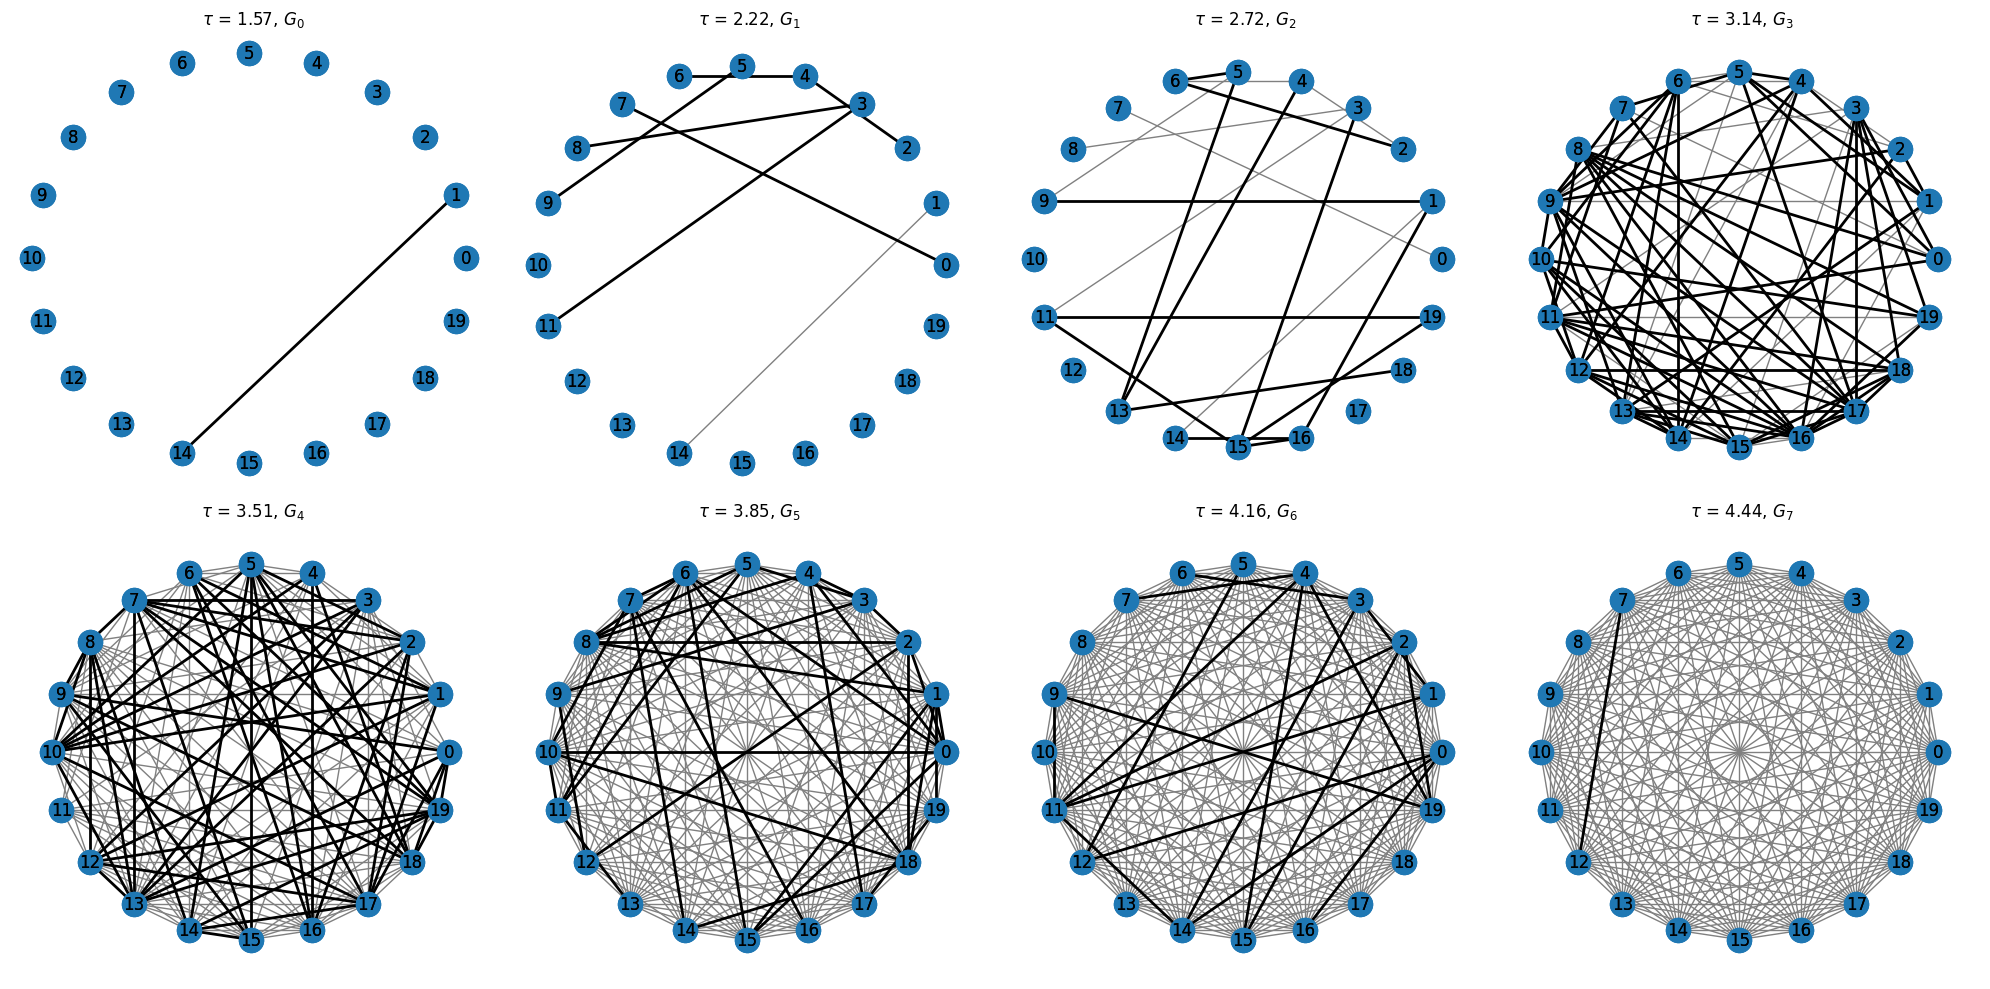

In [140]:
shared_layout = nx.circular_layout(list(Gs.values())[0])  

fig, axes = plt.subplots(2, 4, figsize=(20, 10))  

previous_edges = set() 

axes = axes.flatten()  

for i, (key, graph) in enumerate(Gs.items()):
    current_edges = set(graph.edges())
    
    new_edges = current_edges - previous_edges
    old_edges = current_edges & previous_edges
    
    nx.draw(graph, pos=shared_layout, ax=axes[i], edgelist=old_edges, edge_color='gray', width=1, with_labels=True)
    
    nx.draw(graph, pos=shared_layout, ax=axes[i], edgelist=new_edges, edge_color='black', width=2, with_labels=True)
    
    axes[i].set_title(f' $\\tau$ = {key:.2f}, $G_{{{i}}}$')
    
    previous_edges = current_edges

plt.tight_layout()
plt.show()


In [141]:
noise_levels = [10, 20, 30, 40]
generating_sparsity = [4,8,12,16]

In [143]:
accs = {
    s: {
        SNR: {} for SNR in noise_levels
    } for s in generating_sparsity
}

tvs = {
    s: {
        SNR: {} for SNR in noise_levels
    } for s in generating_sparsity
}

edges_number = {
    s: {
        SNR: {} for SNR in noise_levels
    } for s in generating_sparsity
}

for K in generating_sparsity:
    for SNR in tqdm(noise_levels):
        G = GrassmanGraph(20, 20, K, SNR = SNR, basis = WalshBasis(16), basis_mode = 'Canonic', snaps = 1000)
        S = SheafInference(G, 1e2)

        for t in G.ths:
            acc_, tv_, _ = S.graph_solver(len(G.graphs[t]))
            accs[K][SNR][t] = acc_
            tvs[K][SNR][t] = tv_
            edges_number[K][SNR][t] = len(G.graphs[t])

100%|██████████| 4/4 [00:28<00:00,  7.23s/it]


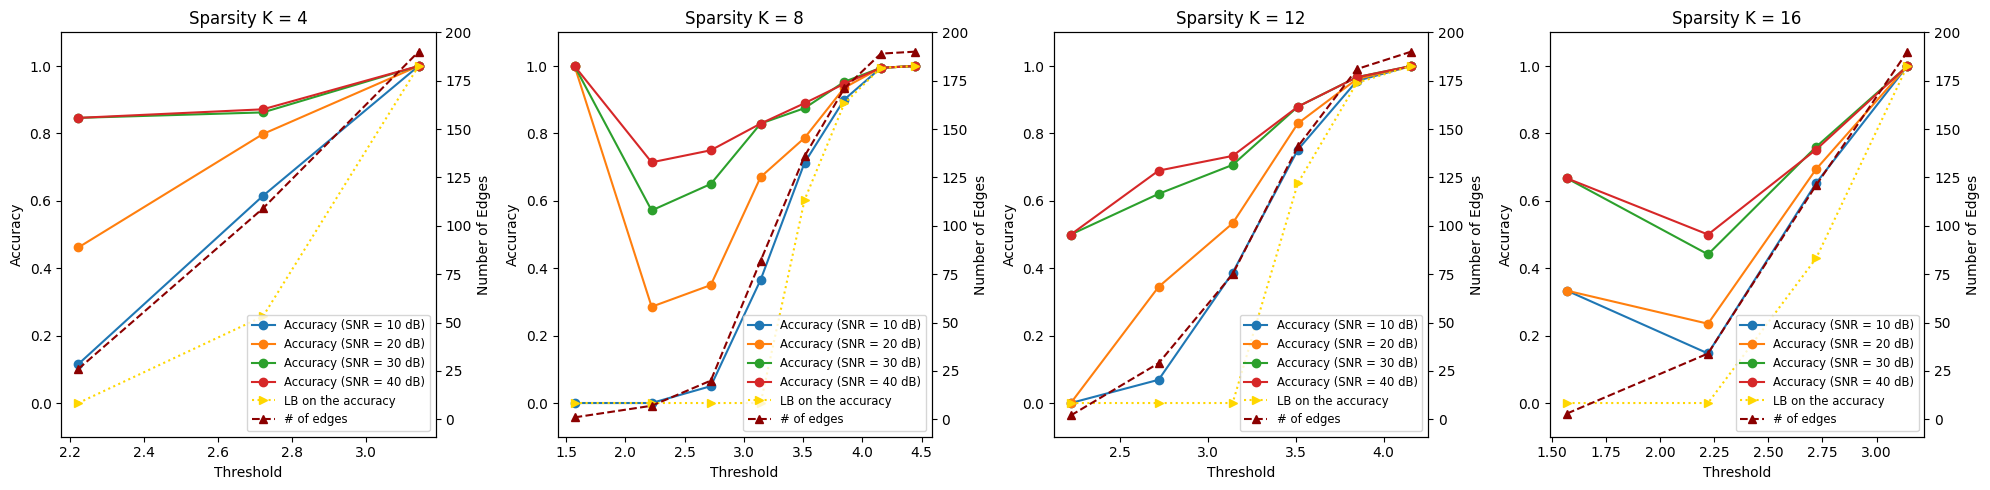

In [145]:
# Create a 1x4 grid of subplots
fig, axs = plt.subplots(1, 4, figsize=(20, 5))

# Flatten the axs array for easier indexing in the loop
axs = axs.flatten()

# Create a separate list for the twin axes
axs_twin = []

# Initialize min and max values for accuracy, number of edges, and new curve
min_acc = 0  # Set min_acc to 0 as per your update
max_acc = 1  # Set max_acc to 1 as per your update
min_edges = float('inf')
max_edges = float('-inf')

# First loop to find the global min and max for number of edges
for j, K in enumerate(generating_sparsity):
    for SNR in noise_levels:
        edges_values = list(edges_number[K][SNR].values())
        min_edges = min(min_edges, min(edges_values))
        max_edges = max(max_edges, max(edges_values))

# Second loop for plotting
for j, K in enumerate(generating_sparsity):
    # Create the twin axis for each subplot
    axs_twin.append(axs[j].twinx())

    # Create a list to store legend handles and labels
    handles, labels = [], []

    for SNR in noise_levels:
        # Plotting accuracy on the primary y-axis with markers
        line, = axs[j].plot(list(accs[K][SNR].keys()), list(accs[K][SNR].values()), 
                            label=f'Acc SNR = {SNR} dB', marker='o')
        handles.append(line)
        labels.append(f'Accuracy (SNR = {SNR} dB)')

        # Compute and plot the additional curve: max(0, 2 - 190/E)
        threshold_list = list(edges_number[K][SNR].keys())
        edges_values = list(edges_number[K][SNR].values())
        new_curve = [max(0, 2 - 190 / E) for E in edges_values]

    # Plot this new curve on the left y-axis
    line, = axs[j].plot(threshold_list, new_curve, label="LB on the accuracy", linestyle=':', color='gold', marker='>')
    handles.append(line)
    labels.append("LB on the accuracy")

    # Plotting edge numbers on the twin y-axis with markers
    line, = axs_twin[j].plot(list(edges_number[K][SNR].keys()), list(edges_number[K][SNR].values()), 
                                label="# of edges", color='darkred', linestyle='--', marker='^')
    handles.append(line)
    labels.append("# of edges")

    # Set labels and title for each subplot
    axs[j].set_title(f'Sparsity K = {K}')
    axs[j].set_xlabel('Threshold')  # Replace with your actual x-axis label
    axs[j].set_ylabel('Accuracy')
    axs_twin[j].set_ylabel('Number of Edges')

    # Set the y-limits for accuracy and number of edges to be consistent
    axs[j].set_ylim(min_acc - 0.1, max_acc + 0.1)
    axs_twin[j].set_ylim(min_edges - 10, max_edges + 10)  # Adjust padding as needed

    # Merge legends
    axs[j].legend(handles, labels, loc='lower right', fontsize='small')

# Adjust layout to avoid overlap
plt.tight_layout()

# Show the plot after all plotting is done
plt.show()


### Second experiment - Random sparsity for $k_{max}$ ranging from 2 to 11

In [34]:
noise_levels = [10, 20, 30, 40]
k_maxs = range(2,12)

In [38]:
accs_random_spars = {
    k_max: {
        SNR: {} for SNR in noise_levels
    } for k_max in k_maxs
}

tvs_random_spars = {
    k_max: {
        SNR: {} for SNR in noise_levels
    } for k_max in k_maxs
}

edges_number_random_spars = {
    k_max: {
        SNR: {} for SNR in noise_levels
    } for k_max in k_maxs
}

for K_max in k_maxs:
    for SNR in tqdm(noise_levels):
        G = GrassmanGraph(20, 20, K = None, K_max = K_max, SNR = SNR, basis_mode = 'Canonic',snaps = 1000)
        S = SheafInference(G, 1e2)

        for t in G.ths:
            acc_, tv_ = S.graph_solver(len(G.graphs[t]))
            accs_random_spars[K_max][SNR][t] = acc_
            tvs_random_spars[K_max][SNR][t] = tv_
            edges_number_random_spars[K_max][SNR][t] = len(G.graphs[t])

100%|██████████| 4/4 [00:26<00:00,  6.68s/it]


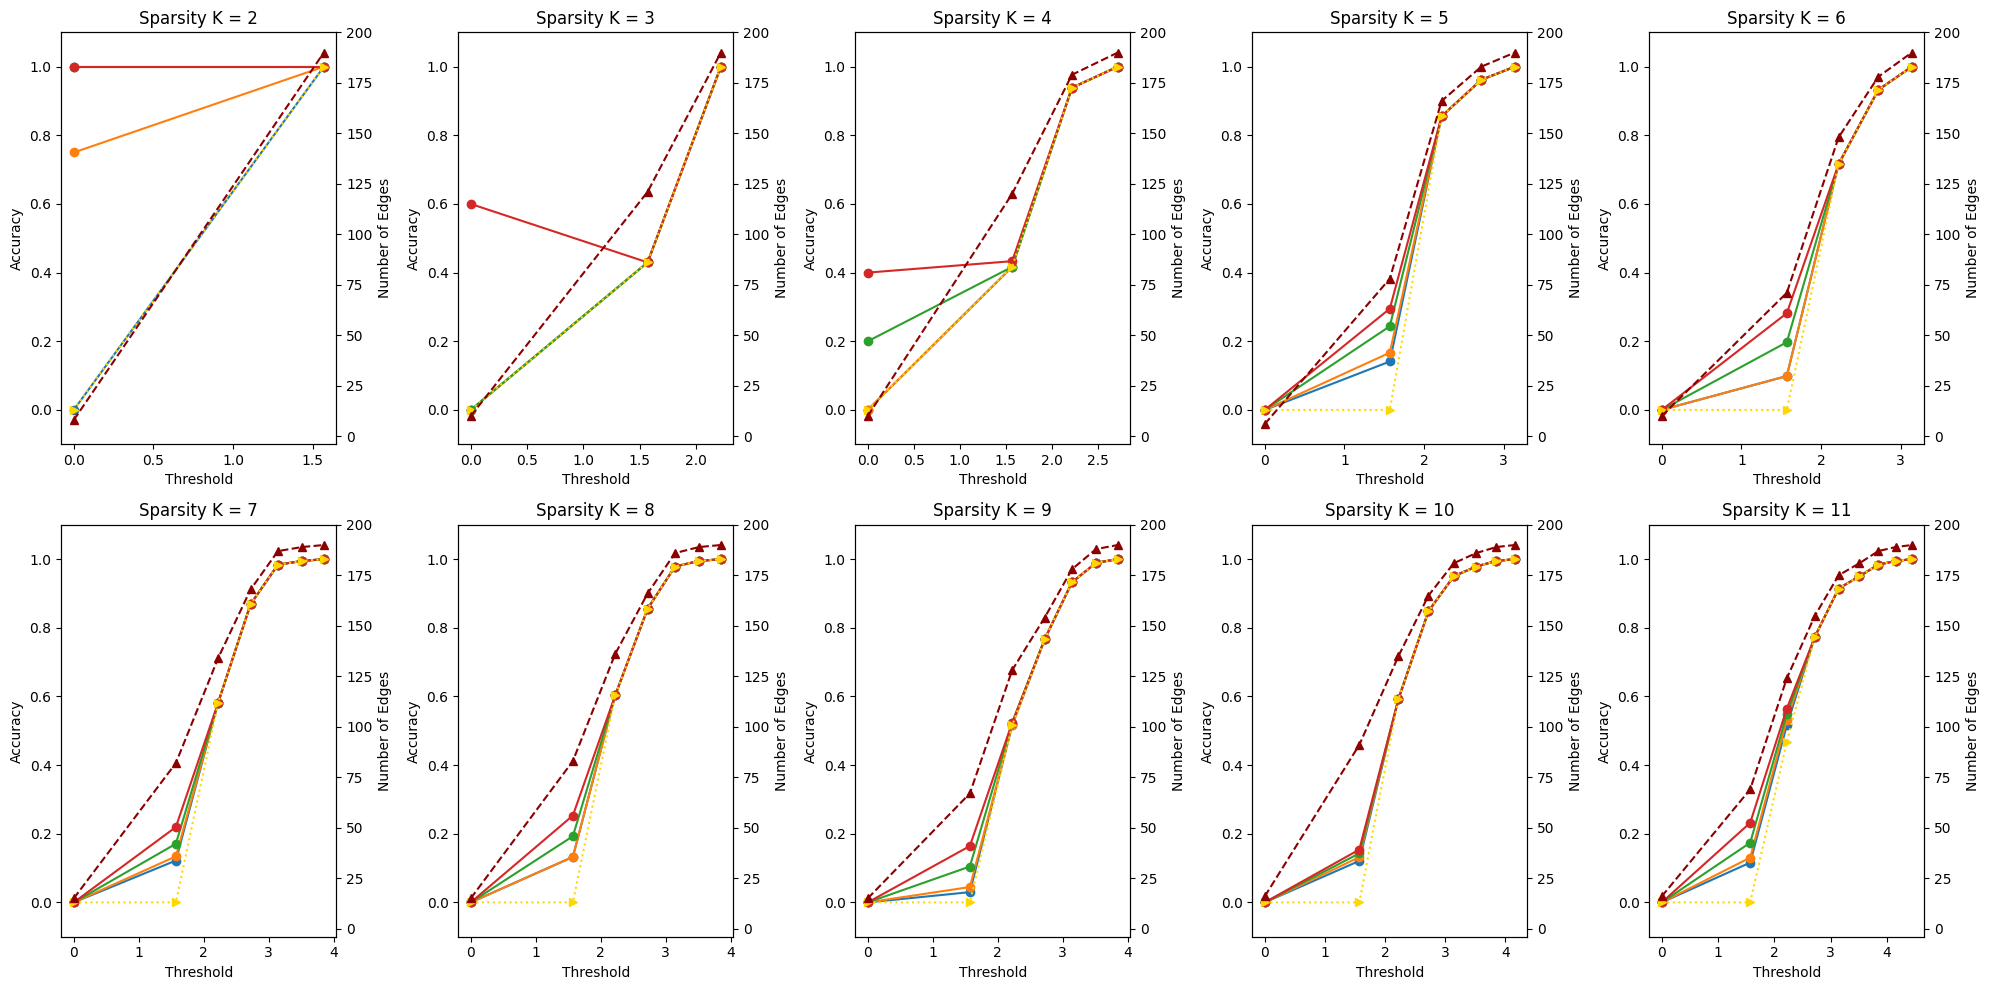

In [43]:
# Create a 2x2 grid of subplots
fig, axs = plt.subplots(2, 5, figsize=(20, 10))

# Flatten the axs array for easier indexing in the loop
axs = axs.flatten()

# Create a separate list for the twin axes
axs_twin = []

# Initialize min and max values for accuracy, number of edges, and new curve
min_acc = 0  # Set min_acc to 0 as per your update
max_acc = 1  # Set max_acc to 1 as per your update
min_edges = float('inf')
max_edges = float('-inf')

# First loop to find the global min and max for number of edges
for j, K in enumerate(k_maxs):
    for SNR in noise_levels:
        edges_values = list(edges_number_random_spars[K][SNR].values())
        min_edges = min(min_edges, min(edges_values))
        max_edges = max(max_edges, max(edges_values))

# Second loop for plotting
for j, K in enumerate(k_maxs):
    # Create the twin axis for each subplot
    axs_twin.append(axs[j].twinx())

    # Create a list to store legend handles and labels
    handles, labels = [], []

    for SNR in noise_levels:
        # Plotting accuracy on the primary y-axis with markers
        line, = axs[j].plot(list(accs_random_spars[K][SNR].keys()), 
                            list(accs_random_spars[K][SNR].values()), 
                            label=f'Acc SNR = {SNR} dB', marker='o')
        handles.append(line)
        labels.append(f'Accuracy (SNR = {SNR} dB)')

        # Compute and plot the additional curve: max(0, 2 - 190/E)
        threshold_list = list(edges_number_random_spars[K][SNR].keys())
        edges_values = list(edges_number_random_spars[K][SNR].values())
    new_curve = [max(0, 2 - 190 / E) for E in edges_values]

    # Plot this new curve on the left y-axis
    line, = axs[j].plot(threshold_list, new_curve, label="LB on the accuracy", linestyle=':', color='gold', marker='>')
    handles.append(line)
    labels.append("LB on the accuracy")

    # Plotting edge numbers on the twin y-axis with markers
    line, = axs_twin[j].plot(list(edges_number_random_spars[K][SNR].keys()), 
                             list(edges_number_random_spars[K][SNR].values()), 
                             label="# of edges", color='darkred', linestyle='--', marker='^')
    handles.append(line)
    labels.append("# of edges")

    # Set labels and title for each subplot
    axs[j].set_title(f'Sparsity K = {K}')
    axs[j].set_xlabel('Threshold')  # Replace with your actual x-axis label
    axs[j].set_ylabel('Accuracy')
    axs_twin[j].set_ylabel('Number of Edges')

    # Set the y-limits for accuracy and number of edges to be consistent
    axs[j].set_ylim(min_acc - 0.1, max_acc + 0.1)
    axs_twin[j].set_ylim(min_edges - 10, max_edges + 10)  # Adjust padding as needed

    # Merge legends
    #axs[j].legend(handles, labels, loc='lower right', fontsize='small')

# Adjust layout to avoid overlap
plt.tight_layout()

# Show the plot after all plotting is done
plt.show()


# Second algorithm - Coupling data generation and inference

In [111]:
class GrassmanGraph:
    def __init__(
            self, 
            N, 
            D, 
            K = None, 
            K_max = None,
            basis = None, 
            SNR = None,
            seed = 42,
            snaps = 1000,
            basis_mode = 'Canonic'
        ):
        
        assert N >= D
        
        self.N = N
        self.D = D
        self.K = K
        self.K_max = K_max
        
        self.snaps = snaps
        self.SNR = SNR
        
        self.basis = basis
        self.basis_mode = basis_mode
        
        self.seed = seed

        self.setup()

    def setup(self):

        self.subSpaceAssignment()
        self.pairwise_distances()
        self.signals_generation()
        self.sorted_connections()
        self.graphs_()

    def subSpaceAssignment(self):
        
        np.random.seed(self.seed)

        # Shared sparsity level
        if self.K is not None:
            return {n: np.random.choice(self.D, self.K, replace = False) for n in range(self.N)}
        else:

            # Random sparsity level
            if self.K_max is not None:
                return {n: np.random.choice(self.D, np.random.randint(1, self.K_max, 1), replace = False) for n in range(self.N)}
            else:
                return {n: np.random.choice(self.D, np.random.randint(1, self.D, 1), replace = False) for n in range(self.N)}

    def GrassmanDistance(
            self,
            U_A,
            U_B
        ):
        
        k, l = U_A.shape[1], U_B.shape[1]
        
        _, S, _ = np.linalg.svd(U_A.T @ U_B)
        S = np.clip(S, -1.0, 1.0)
        
        return np.linalg.norm(np.arccos(S[0:min([k,l])]))

    
    def pairwise_distances(self):
        self.SSA = self.subSpaceAssignment()

        if self.basis_mode == 'Canonic':
            self.basis = np.eye(self.D)
        else:
            self.basis = self.basis

        self.pair_wise_subspaces_distance = {
            edge: self.GrassmanDistance(self.basis[:,self.SSA[edge[0]]], self.basis[:,self.SSA[edge[1]]])
            for edge in list(combinations(range(self.N), 2))
            }
        
    def sorted_connections(self):
        
        self.edges = [e[0] for e in sorted(self.pair_wise_subspaces_distance.items(), key = lambda x: x[1])]

    def graphs_(self):

        self.ths = np.unique([d for d in self.pair_wise_subspaces_distance.values()])

        self.graphs = {
            t: [edge for edge in self.edges if self.pair_wise_subspaces_distance[edge] <= t]
            for t in self.ths
        }

    def signals_generation(self):

        def noise(signal):
            if self.SNR is None:
                return np.zeros_like(signal)

            signal_power = np.sum(np.square(signal), axis=0, keepdims=True)
            snr_linear = 10**(self.SNR / 10)
            noise_power = signal_power / snr_linear

            noise = np.sqrt(noise_power) * np.random.randn(*signal.shape)

            return noise
        
        np.random.seed(self.seed)
        self.signals = {
                node: (
                        signal := self.basis[:, self.SSA[node]] @ np.random.randn(len(self.SSA[node]), self.snaps)
                    ) + noise(signal)                
                for node in range(self.N)
                }

In [131]:
class SheafInference:
    def __init__(
            self, 
            GG, 
            mu,
            K0,
            gamma,
            verbose = False):
        
        self.GG = GG 
        self.mu = mu

        self.K0 = K0
        self.gamma = gamma

        self.verbose = verbose

        self.codebook = copy(self.GG.signals)

        self.F = {
            edge: {
                edge[0]:np.eye(self.GG.D),
                edge[1]:np.eye(self.GG.D)
            } for edge in combinations(range(self.GG.N), 2)
        }

        self.losses = [np.inf]

    #####################################################################
    ######################## MAPS SOLVER METHODS ########################
    #####################################################################

    def premultiplier(self, Xu, Xv, beta = 1e-3):
        A11 = np.kron((Xu @ Xu.T), np.eye(self.GG.D)) + beta * np.eye(self.GG.D**2)
        A12 = - np.kron((Xu @ Xv.T), np.eye(self.GG.D))
        A21 = - np.kron((Xv @ Xu.T), np.eye(self.GG.D))
        A22 = np.kron((Xv @ Xv.T), np.eye(self.GG.D)) + beta * np.eye(self.GG.D**2)

        return np.block([[A11, A12], [A21, A22]])

    def solver(self, Xu, Xv): 
        A = self.premultiplier(Xu, Xv)
        b = np.block([[np.eye(self.GG.D).flatten().reshape(-1,1)],[np.eye(self.GG.D).flatten().reshape(-1,1)]])

        sol = np.linalg.solve(A,b)

        Fu = sol[0:self.GG.D*self.GG.D,:]
        Fv = sol[self.GG.D*self.GG.D:,:]

        return Fu.reshape(self.GG.D,self.GG.D), Fv.reshape(self.GG.D,self.GG.D)
    
    def KKT_solver(self):
        T = 0

        H = {
            edge : {
                edge[0] : None,
                edge[1] : None
            }
        for edge in combinations(range(self.GG.N), 2)
        }

        for e in combinations(range(self.GG.N),2):
            u = e[0]
            v = e[1]

            X_u = self.GG.basis @ self.codebook[u]
            X_v = self.GG.basis @ self.codebook[v]

            Fu, Fv = self.solver(X_u, X_v)

            H[e][u] = Fu
            H[e][v] = Fv
            
            T += np.trace(H[e][u]) + np.trace(H[e][v])

        self.F = {
            edge : {
                edge[0] : - self.mu/T * (H[edge][edge[0]]),
                edge[1] : - self.mu/T * (H[edge][edge[1]])
            }
        for edge in combinations(range(self.GG.N), 2)
        }

    ############################################################################
    ######################## GROUP-SPARSE CODER METHODS ########################
    ############################################################################

    def NodeCodebookUpdate_precomputations(self):

        Phi = {
            node: np.zeros((self.GG.D,self.GG.D)) for node in range(self.GG.N)
            }
        
        Theta = {
            node: np.zeros((self.GG.D,self.GG.snaps)) for node in range(self.GG.N)
            }

        for edge in combinations(range(self.GG.N),2):
            Phi[edge[0]] += self.GG.basis.T @ self.F[edge][edge[0]].T @ self.F[edge][edge[0]] @ self.GG.basis
            Theta[edge[0]] += self.GG.basis.T @ self.F[edge][edge[0]].T @ self.F[edge][edge[1]] @ self.GG.basis @ self.codebook[edge[1]]
            Phi[edge[1]] += self.GG.basis.T @ self.F[edge][edge[1]].T @ self.F[edge][edge[1]] @ self.GG.basis
            Theta[edge[1]] += self.GG.basis.T @ self.F[edge][edge[1]].T @ self.F[edge][edge[0]] @ self.GG.basis @ self.codebook[edge[0]]

        return Phi, Theta
    
    def NodeCodebookUpdate(self):
        
        def prox21_col(x):
                
            return ( 1 - self.gamma / (np.max([np.linalg.norm(x), self.gamma])) ) * x
        
        def prox21(X):

            norms = np.linalg.norm(X, axis=1)
            top_k_indices = np.argsort(norms)[-self.K0:]
            trusted_support = np.copy(X[top_k_indices,:])
            X[top_k_indices,:] = 0
            X = np.apply_along_axis(prox21_col, axis = 1, arr = X)
            X[top_k_indices,:] = trusted_support
            return X

        def ProxGradDescent(Phi, Theta, node, LR = 3e-3, MAXITER = 50, eps = 1e-2):
            if self.codebook[node] is None:
                S = np.zeros((self.GG.D, self.GG.snaps))
            else:
                S = self.codebook[node]

            loss = np.linalg.norm(self.GG.signals[node])

            for _ in range(MAXITER):
                # Gradient update: x_new = x_old + step_size * D^T (y - D * x_old)
                gradient = (self.GG.basis.T @ self.GG.basis + Phi[node]) @ S - self.GG.basis.T @ self.GG.signals[node] - Theta[node]
                S = S - LR * gradient
                
                # Hard thresholding: keep only the k largest entries
                S = prox21(S)
                
                temp = np.linalg.norm(self.GG.signals[node] - self.GG.basis @ S)
                if loss - temp < eps:
                    break
                else:
                    loss = temp
            return S
        
        Phi, Theta = self.NodeCodebookUpdate_precomputations()

        for node in range(self.GG.N):
            self.codebook[node] = ProxGradDescent(Phi, Theta, node)

    ############################################################################
    ################# FULL PIPELINE VIA ALTERNATED OPTIMIZATION ################
    ############################################################################

    def AlternatedOptimization(self, MAXITER = 100, eps = 1e-2):
        
        for _ in tqdm(range(MAXITER)):
            self.NodeCodebookUpdate()
            self.KKT_solver()

            loss = 0
            patience = 0

            for v in range(self.GG.N):
                loss += np.linalg.norm(self.GG.signals[v] - self.GG.basis @ self.codebook[v])

            for edge in combinations(range(self.GG.N),2):
                loss += np.linalg.norm(self.F[edge][edge[0]] @ self.GG.signals[edge[0]] - self.F[edge][edge[1]] @ self.GG.signals[edge[1]])

            if self.losses[len(self.losses)-1] - loss < eps:
                break
            else:
                self.losses.append(loss)
            
            
    def EdgeRetriever(self):

        all_edges = list(combinations(range(self.GG.N), 2))

        energies = {
            e : 0
            for e in all_edges
            }

        for e in all_edges:

            energies[e] = np.linalg.norm(self.F[e][e[0]] @ self.GG.basis @ self.codebook[e[0]] - self.F[e][e[1]] @ self.GG.basis @ self.codebook[e[1]])

        self.retrieved = sorted(energies.items(), key=lambda x:x[1])

    def GraphSolver(self, E0):

        self.EdgeRetriever()

        acc = len(set(list(map(lambda x: x[0], self.retrieved[:E0]))).intersection(set(self.GG.edges[:E0]))) / E0

        edges_subset = list(set(list(map(lambda x: x[0], self.retrieved[:E0]))).intersection(set(self.GG.edges[:E0])))
        B = np.zeros((self.GG.N * self.GG.D, len(edges_subset)*self.GG.D))

        for j, edge in enumerate(edges_subset):
            u = edge[0]
            v = edge[1]

            B[u*self.GG.D:(u+1)*self.GG.D,j*self.GG.D:(j+1)*self.GG.D] = self.F[edge][u]
            B[v*self.GG.D:(v+1)*self.GG.D,j*self.GG.D:(j+1)*self.GG.D] = - self.F[edge][v]

        Lf = B @ B.T

        Y = np.vstack(list(self.GG.signals.values()))
        tv = np.trace(Y.T @ Lf @ Y)

        if self.verbose:
            print(f'Accuracy in retrieving underlying graph {acc}, with total variation {tv}')
        return acc, tv

In [132]:
noise_levels = [10, 20, 30, 40]
generating_sparsity = [3,6,9,12]

In [133]:
accs = {
    s: {
        SNR: {} for SNR in noise_levels
    } for s in generating_sparsity
}

tvs = {
    s: {
        SNR: {} for SNR in noise_levels
    } for s in generating_sparsity
}

edges_number = {
    s: {
        SNR: {} for SNR in noise_levels
    } for s in generating_sparsity
}

for K in generating_sparsity:
    for SNR in tqdm(noise_levels):
        G = GrassmanGraph(16, 16, K, SNR = SNR, basis=WalshBasis(16), basis_mode = 'Walsh', snaps = 1000)
        S = SheafInference(G, 1e2, K, 0.1)
        S.AlternatedOptimization()

        for t in G.ths:
            acc_, tv_ = S.GraphSolver(len(G.graphs[t]))
            accs[K][SNR][t] = acc_
            tvs[K][SNR][t] = tv_
            edges_number[K][SNR][t] = len(G.graphs[t])

100%|██████████| 4/4 [18:50<00:00, 282.74s/it]


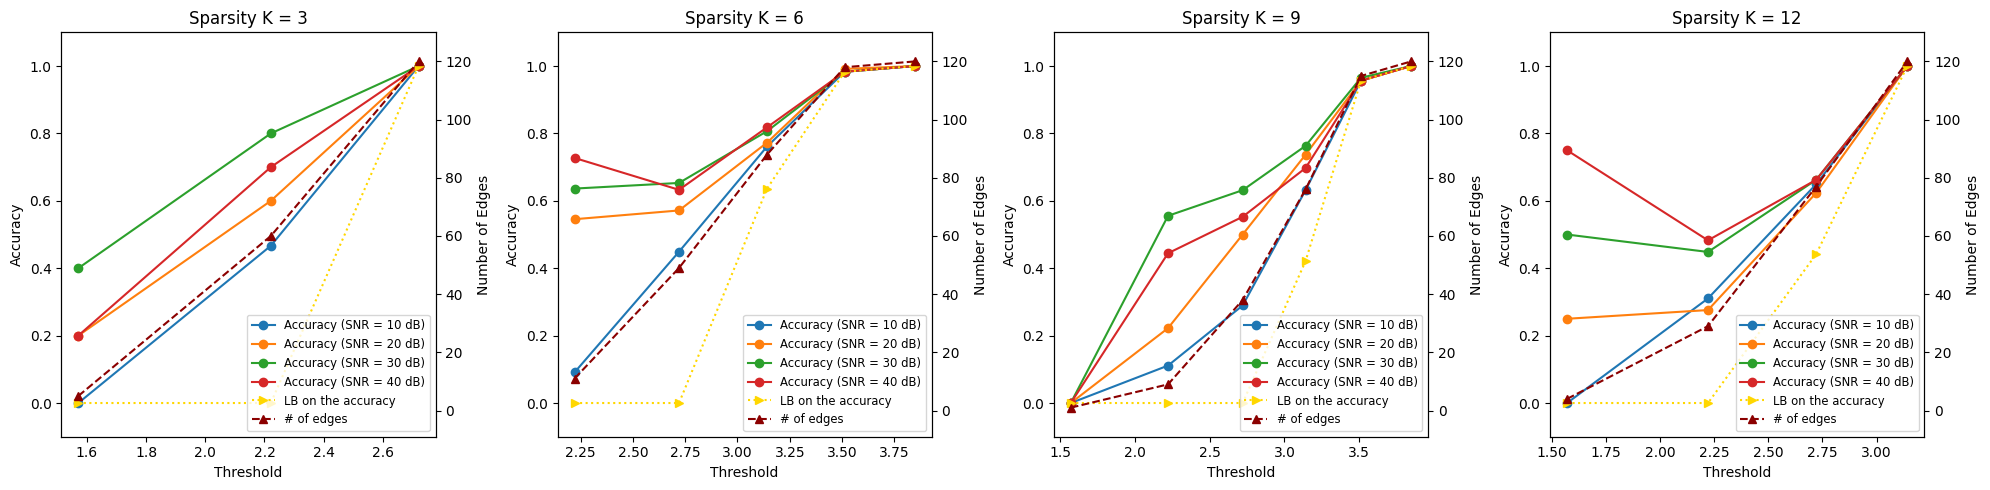

In [135]:
# Create a 1x4 grid of subplots
fig, axs = plt.subplots(1, 4, figsize=(20, 5))

# Flatten the axs array for easier indexing in the loop
axs = axs.flatten()

# Create a separate list for the twin axes
axs_twin = []

# Initialize min and max values for accuracy, number of edges, and new curve
min_acc = 0  # Set min_acc to 0 as per your update
max_acc = 1  # Set max_acc to 1 as per your update
min_edges = float('inf')
max_edges = float('-inf')

# First loop to find the global min and max for number of edges
for j, K in enumerate(generating_sparsity[0:4]):
    for SNR in noise_levels:
        edges_values = list(edges_number[K][SNR].values())
        min_edges = min(min_edges, min(edges_values))
        max_edges = max(max_edges, max(edges_values))

# Second loop for plotting
for j, K in enumerate(generating_sparsity):
    # Create the twin axis for each subplot
    axs_twin.append(axs[j].twinx())

    # Create a list to store legend handles and labels
    handles, labels = [], []

    for SNR in noise_levels:
        # Plotting accuracy on the primary y-axis with markers
        line, = axs[j].plot(list(accs[K][SNR].keys()), list(accs[K][SNR].values()), 
                            label=f'Acc SNR = {SNR} dB', marker='o')
        handles.append(line)
        labels.append(f'Accuracy (SNR = {SNR} dB)')

        # Compute and plot the additional curve: max(0, 2 - 190/E)
        threshold_list = list(edges_number[K][SNR].keys())
        edges_values = list(edges_number[K][SNR].values())
        new_curve = [max(0, 2 - 120 / E) for E in edges_values]

    # Plot this new curve on the left y-axis
    line, = axs[j].plot(threshold_list, new_curve, label="LB on the accuracy", linestyle=':', color='gold', marker='>')
    handles.append(line)
    labels.append("LB on the accuracy")

    # Plotting edge numbers on the twin y-axis with markers
    line, = axs_twin[j].plot(list(edges_number[K][SNR].keys()), list(edges_number[K][SNR].values()), 
                                label="# of edges", color='darkred', linestyle='--', marker='^')
    handles.append(line)
    labels.append("# of edges")

    # Set labels and title for each subplot
    axs[j].set_title(f'Sparsity K = {K}')
    axs[j].set_xlabel('Threshold')  # Replace with your actual x-axis label
    axs[j].set_ylabel('Accuracy')
    axs_twin[j].set_ylabel('Number of Edges')

    # Set the y-limits for accuracy and number of edges to be consistent
    axs[j].set_ylim(min_acc - 0.1, max_acc + 0.1)
    axs_twin[j].set_ylim(min_edges - 10, max_edges + 10)  # Adjust padding as needed

    # Merge legends
    axs[j].legend(handles, labels, loc='lower right', fontsize='small')

# Adjust layout to avoid overlap
plt.tight_layout()

# Show the plot after all plotting is done
plt.show()


# Third experiment - Evaluating reconstruction error

In [174]:
def BOMP(Y, D, K):

    S = []

    X = np.zeros((D.shape[1], Y.shape[1]))
    iters = 0
    R = Y

    coder = {}
    while iters < K:

        # Retrieve the maximum correlation between atoms and residuals of the previous iteration
        S.append(np.argmax(np.linalg.norm(D.T @ R, axis = 1)))

        # Expand the dictionary for the representation
        dic = D[:,S]

        # Solve subproblems and update x
        X[S] = np.linalg.pinv(dic) @ Y
        coder[iters] = np.copy(X)

        # Update the residuals
        R = Y - D @ X
        iters += 2

    return coder

In [175]:
G = GrassmanGraph(20, 20, 8, SNR = 40, basis_mode = 'Canonic', snaps = 1000)
S = SheafInference(G, 1e2)

distortions = {}
for t in tqdm(G.ths):
    _, _, Lf = S.graph_solver(len(G.graphs[t]))
    distortions[t] = np.zeros(100)
    _, U = np.linalg.eig(Lf)
    Y = np.vstack([G.signals[v] for v in range(G.N)])

    X = BOMP(Y, U, 200)
    distortions[t] = np.array([np.linalg.norm(Y - U @ X[k])*0.001 for k in X.keys()])

100%|██████████| 8/8 [05:11<00:00, 38.92s/it]


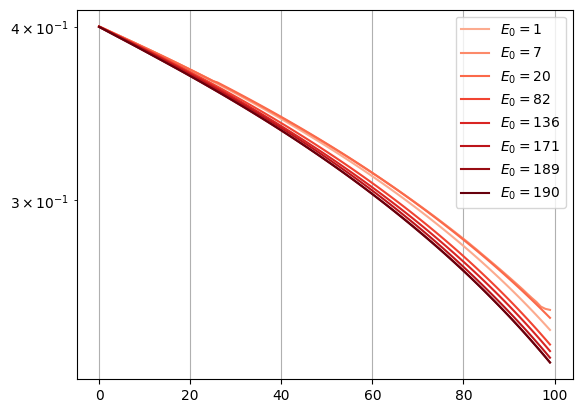

In [178]:
markers = ['o', 's', '^', 'D', 'v', '<', '>', '*']
colors = plt.cm.Reds(np.linspace(0.3, 1, len(G.ths)))  # Shades of red

# Plot each line with unique marker and color
for idx, t in enumerate(G.ths):
    plt.plot(range(0, 100), distortions[t], label=f'$E_0 = ${len(G.graphs[t])}',
             color=colors[idx], linestyle='-', markersize=6)

# Add grid and legend
plt.grid(True)
plt.yscale('log')
plt.legend()
plt.show()

In [171]:
distortions

{1.5707963267948966: array([0.24210817, 0.24210817, 0.24210817, 0.24210817, 0.24210817,
        0.24210817, 0.24210817, 0.24210817, 0.24210817, 0.24210817,
        0.24210817, 0.24210817, 0.24210817, 0.24210817, 0.24210817,
        0.24210817, 0.24210817, 0.24210817, 0.24210817, 0.24210817,
        0.24210817, 0.24210817, 0.24210817, 0.24210817, 0.24210817,
        0.24210817, 0.24210817, 0.24210817, 0.24210817, 0.24210817,
        0.24210817, 0.24210817, 0.24210817, 0.24210817, 0.24210817,
        0.24210817, 0.24210817, 0.24210817, 0.24210817, 0.24210817,
        0.24210817, 0.24210817, 0.24210817, 0.24210817, 0.24210817,
        0.24210817, 0.24210817, 0.24210817, 0.24210817, 0.24210817,
        0.24210817, 0.24210817, 0.24210817, 0.24210817, 0.24210817,
        0.24210817, 0.24210817, 0.24210817, 0.24210817, 0.24210817,
        0.24210817, 0.24210817, 0.24210817, 0.24210817, 0.24210817,
        0.24210817, 0.24210817, 0.24210817, 0.24210817, 0.24210817,
        0.24210817, 0.242108